In [1]:
import sys
sys.path.append('../')

import argparse
import csv
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from keras.preprocessing import image
from src.func_utils import read_from_csv, load_keras_model, image_to_tensor

Using TensorFlow backend.


In [2]:
# Define relative paths to model and csv files
# Download pre-trained model here https://drive.google.com/open?id=1repdxph5crkJKgUdQTCLhpWhDi3l3rXp
model_path = os.path.join('..','snapshots','DenseNet169-epochs-47-0.26.h5')
class_csv = os.path.join('..','dataframe','csv_files','class.csv')
test_csv = os.path.join('..','dataframe','csv_files','cars_test_crop.csv')
false_prediction_csv = os.path.join('..','dataframe','csv_files','false_prediction.csv')

In [3]:
# Load class list and assign to dictionary to map back the class number to the name of the car
class_list = read_from_csv(class_csv, 2)
class_dict = {int(car[1]):car[0] for car in class_list}

# Read the csv cropped file and convert it to array of [file_path, car_id]
evaluate_list = read_from_csv(test_csv, 2)

# Load the model for prediction
model = load_keras_model(model_path)

In [4]:
# Initialize variables and array
true_pred = 0
false_pred = 0
y_preds = []
y_test = []

In [5]:
# Open new csv file to save log of false prediction
open_csv = open(false_prediction_csv, mode="w", newline="")
write_csv = csv.writer(open_csv, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)

# Loop the car list and predict each one
for car in evaluate_list:
    file_path = os.path.join('..', str(car[0]))
    car_id = int(car[1])

    # Load, resize, convert to 4D tensor and normalize image before prediction
    x = image_to_tensor(file_path, 224)
    preds = model.predict(x)

    # Get the class index of highest probability result
    category_preds = int(np.argmax(preds)) + 1

    # Create list of predictions and ground truth to be feed into sklearn classification_report
    y_preds.append(category_preds)
    y_test.append(car_id)

    # Log true and false prediction, write false prediction to csv
    if category_preds == car_id:
        true_pred += 1
    else:
        false_pred += 1
        write_csv.writerow([class_dict[car_id], class_dict[category_preds], np.max(preds)])

open_csv.close()

In [6]:
print("Number of true prediction: ",true_pred, "Number of false prediction: ",false_pred)
print("Accuracy: {:.3f}% ".format(100*(true_pred/(true_pred + false_pred))))

print(classification_report(y_test, y_preds))

Number of true prediction:  7326 Number of false prediction:  715
Accuracy: 91.108% 
             precision    recall  f1-score   support

          1       0.89      0.91      0.90        44
          2       0.91      0.91      0.91        32
          3       0.86      0.98      0.91        43
          4       1.00      1.00      1.00        42
          5       0.94      0.85      0.89        40
          6       0.93      0.98      0.96        44
          7       0.95      0.90      0.92        39
          8       0.84      0.80      0.82        45
          9       0.85      0.80      0.83        41
         10       0.90      0.85      0.88        33
         11       0.78      0.92      0.84        38
         12       0.83      0.83      0.83        36
         13       0.66      0.85      0.74        41
         14       0.62      0.60      0.61        42
         15       0.93      0.88      0.90        43
         16       0.78      0.67      0.72        43
         17  

## Plotting random image selection and its prediction

In [12]:
# Choose 4 random images from test set
rand_selection = [random.randint(1,len(evaluate_list)) for i in range(4)]
print(rand_selection)

[8005, 5167, 1462, 3291]


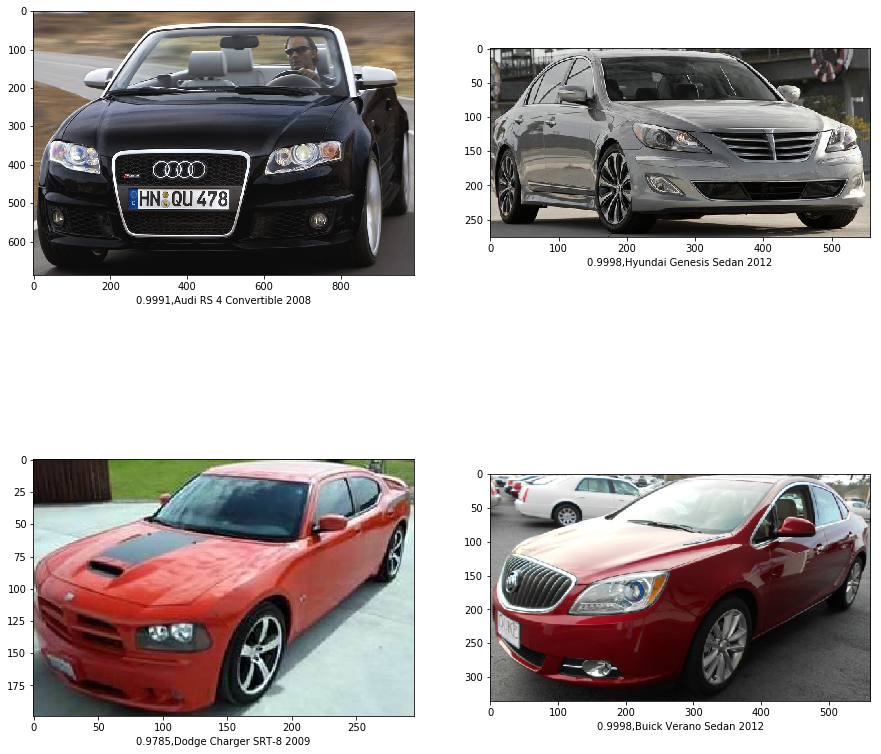

In [13]:
# Predict and display the images together with its predicted label
plt.figure(figsize = (15,15))

for i, selection in enumerate(rand_selection):
    car = evaluate_list[selection]
    file_path = os.path.join('..', str(car[0]))
    car_id = int(car[1])
    
    img_plot = image.load_img(file_path)
    x = image_to_tensor(file_path, 224)
    preds = model.predict(x)
    probability = np.max(preds)
    
    category_preds = int(np.argmax(preds)) + 1
    label = '{:.4f},{}'.format(probability, class_dict[category_preds])
    plt.subplot(2, 2, i+1), plt.imshow(img_plot), plt.xlabel(label)

plt.show()